<a href="https://colab.research.google.com/github/hsh6449/TIL/blob/main/AI/RL/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN Reproduce

## 0. load library

reference
- https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H#scrollTo=bYDe8axLdI1E (RL Environment setting 1)
- https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html (Main code)
-https://engineering-ladder.tistory.com/61 (RL Environment setting 2)

In [1]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install piglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys

IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
  !apt update && apt install -y libsdq-dev libsdl2-dev swig xorg-dev xvfb
  %pip install -U tf-agents pyvertualdisplay
  %pip install gym
  %pip install gym[box2d,atari,accept-rom-license]
!xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state info

In [3]:
#!pip install gym[atari]
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import os
'''
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
    '''

import io
import base64
from IPython.display import HTML

from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only

%matplotlib inline

import glob
from IPython import display as ipythondisplay

In [5]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [6]:
env = gym.make('CartPole-v0').unwrapped

In [5]:
'''
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
'''

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
# 재현메모리 이용
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [9]:
class ReplayMemory(object):
  
  def __init__(self, capacity):
    self.memory = deque([], maxlen = capacity)
  
  def push(self, *args):
    """transition 저장"""
    self.memory.append(Transition(*args))
  
  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)
  
  def __len__(self):
    return len(self.memory)

## 1. DQN

In [10]:
# 기본적으로 두가지 아웃풋 -> 주어진 현재 입력에서 기댓값 예측
class DQN(nn.Module):

  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size= 5, stride = 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride = 2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)

    def conv2d_size_out(size, kernel_size = 5, stride = 2):
      return (size - (kernel_size - 1) - 1) // stride  + 1
        
    convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
    convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
    linear_input_size = convw * convh * 32
    self.head = nn.Linear(linear_input_size, outputs)

  def forward(self, x):
    x = x.to(device)
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    return self.head(x.view(x.size(0), -1))

In [11]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [12]:
def get_cart_location(screen_width):
  world_width = env.x_threshold * 2
  scale = screen_width / world_width
  return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

In [13]:
def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만 큰 경우에 Torch order (CHW)로 변환한다.   
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)

In [25]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [14]:
#env.unwrapped.x_threshold = -1
#get_screen().cuda().squeeze(0).permute(1, 2, 0).shape, get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy().shape

In [ ]:
env.reset()
plt.figure(figsize=(15,15))
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='spline16')
plt.title('Example extracted screen')
plt.show()

Exception in callback BaseAsyncIOLoop._handle_events(14, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(14, 1)>
Traceback (most recent call last):
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.7/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.7/dist-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.7/dist-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tornado/stack_con

In [16]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# AI gym에서 반환된 형태를 기반으로 계층을 초기화 하도록 화면의 크기를
# 가져옵니다. 이 시점에 일반적으로 3x40x90 에 가깝습니다.
# 이 크기는 get_screen()에서 고정, 축소된 렌더 버퍼의 결과입니다.
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### 1) 코드 파헤치기

In [35]:
net = DQN(screen_height, screen_width, 2).to(device)
net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [37]:
policy_net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0824,  0.0922, -0.0876, -0.0981,  0.0846],
                        [-0.0890,  0.0998, -0.0968,  0.0917, -0.1078],
                        [-0.0408,  0.0905, -0.0789, -0.0521, -0.0820],
                        [-0.0520,  0.0298,  0.0581, -0.0425, -0.0250],
                        [-0.0814,  0.0648,  0.0240, -0.0241,  0.0468]],
              
                       [[-0.0944, -0.0554, -0.0436,  0.0691,  0.0692],
                        [ 0.1051, -0.0898,  0.0128, -0.0768,  0.0671],
                        [ 0.0591, -0.0676,  0.1128,  0.0084,  0.0823],
                        [-0.0899,  0.0961,  0.0404,  0.0586,  0.0939],
                        [-0.1150,  0.0443,  0.0598, -0.1098, -0.0863]],
              
                       [[ 0.1080,  0.0387, -0.0514, -0.0662,  0.0016],
                        [ 0.0452,  0.0439, -0.0899, -0.0499,  0.1029],
                        [-0.0964, -0.0019,  0.0727,  0.1117,  0.0157],
               

In [23]:
get_screen().shape

torch.Size([1, 3, 40, 90])

In [28]:
env.action_space.shape

()

In [32]:
target_net

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
net.state_dict().items() #!= policy_net.state_dict()[0])

In [47]:
net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=512, out_features=2, bias=True)
)

In [52]:
net.parameters

<bound method Module.parameters of DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=512, out_features=2, bias=True)
)>

In [57]:
EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

0.9

In [56]:
EPS_END +(EPS_START - EPS_END)

0.9

## Training

In [17]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결합니다
    # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### 2) 코드 파헤치기 

In [67]:
temp_memory = ReplayMemory(4000)

In [72]:
temp_memory.sample(BATCH_SIZE)

ValueError: ignored

In [71]:
Transition(*zip(*transitions))

NameError: ignored

## 학습

In [37]:
num_episodes = 50
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # 행동 선택과 수행
        action = select_action(state)
        print(action)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # 새로운 상태 관찰
        last_screen = current_screen
        current_screen = get_screen()
        print(current_screen)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # 목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [36]:
env.step(1)

(array([ 0.13818151,  0.7907343 , -0.23729845, -1.46290434]), 0.0, True, {})

In [49]:
get_screen()[0,2,1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## *Gym이랑 친해져 보자..!

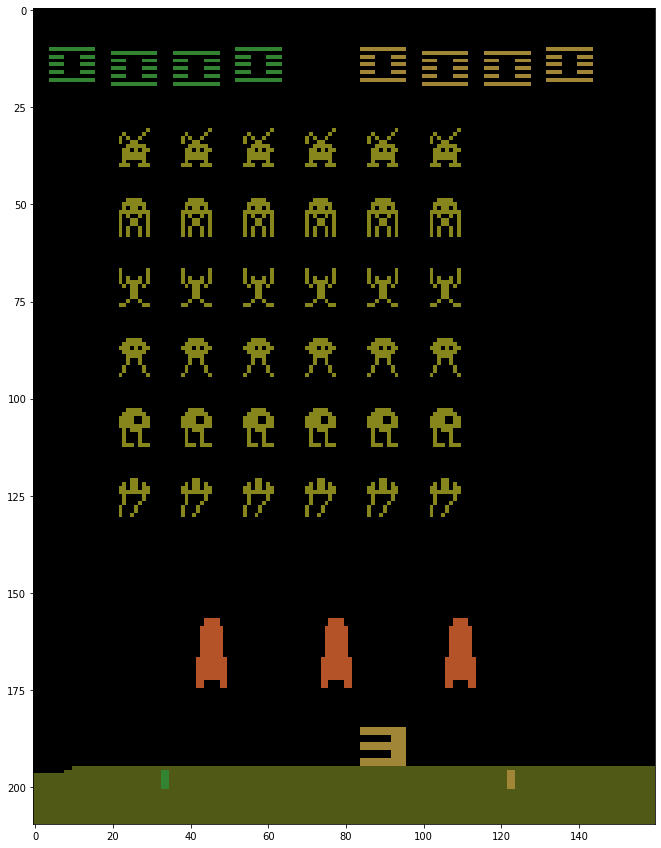

In [27]:
env = gym.make('SpaceInvaders-v0')
env.reset()
plt.figure(figsize=(15,15))
plt.imshow(env.render('rgb_array'))

In [30]:
env = gym.make('Copy-v0')
env.reset()
#plt.imshow(env.render())
env.render()

Total length of input instance: 3, step: 0
Observation Tape    :   AAE  
Output Tape         :   
Targets             :   AAE  








In [15]:
env = gym.make("FrozenLake-v0")
observation = env.reset()
observation

0

In [16]:
for _ in range(100):
  env.render()
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down

In [20]:
# unwrapped한것과 안한것의 차이는?
env = gym.make('CartPole-v0').unwrapped
env2 = gym.make('CartPole-v0')

In [21]:
env2

<TimeLimit<CartPoleEnv<CartPole-v0>>>

In [22]:
env

In [23]:
env3 = gym.make('FrozenLake-v0').unwrapped

In [24]:
env3

In [25]:
observation = env.reset()
for _ in range(100):
  env.render()
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)

In [29]:
env.step(1) #(observation, reward, done, info)

(array([ 2.01397114, -0.13940001, -7.82332334, -5.18138904]), 0.0, True, {})